In [2]:
import requests
import datetime
import time
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns; sns.set()
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d-%H")
def get_visit_list(s):
    data={}
    data['visit_list'] = s['用户ID'].tolist()
    return pd.Series(data)
def get_order_people(s):
    data={}
    data['会员人数']=s['会员ID'].tolist()
    return pd.Series(data)

In [13]:
def large_user_order(date):
    dsl ={'aggs': {'my_buckets': {'aggregations': {},
                             'composite': {'size': 9999999,
                                           'sources': [{'用户ID':{'terms':{'field':'user_id'}}},]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                        'gte': date,
                                                        'lte': date,
                                                        'time_zone': '+00:00'}}},
                                 {'terms': {'group_city': ['阳江市']}},
                                 {'terms': {'order_type': ['vip_scan', 'deal']}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}},
                                 {'range': {'card_discount': {'gt': 0}}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    df1=df[df['doc_count']!=1]
    
    
    user_list=df1['用户ID'].tolist()
    bar=progressbar
    a=[]
    for i in bar.progressbar(user_list):
        dsl ={'aggs': {'my_buckets': {'aggregations': {},
                                 'composite': {'size': 9999999,
                                               'sources': [{"单号": {"terms": {"field": 'order_id'}}},
                                                           {"单价": {"terms": {"field": 'skutotal_price'}}},
                                                           {'时间': {'date_histogram': {'field': 'paytime',
                                                                                   'interval': '1h',
                                                                                      'time_zone': '+00:00'}}}
                                                          ]}}},
         'query': {'bool': {'must': [{'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                            'gte': date,
                                                            'lte': date,
                                                            'time_zone': '+00:00'}}},
                                     {'terms': {'group_city': ['阳江市']}},
                                     {'terms': {'order_type': ['vip_scan', 'deal']}},
                                     {'terms': {'order_status': ['done',
                                                                 'fulfilled',
                                                                 'confirmed']}},
                                     {'range': {'card_discount': {'gt': 0}}},
                                     {'terms': {'user_id': [i]}}]
                           }}}
        es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
        res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
        df = json_normalize(res['aggregations']['my_buckets']['buckets'])
        df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
        df['时间'] = df['时间'].apply(to_date)
        df['时间'] = pd.to_datetime(df['时间'])
        
        df_new=df[df['单价']<300]
        
        def get_order_time(s):
            data={}
            data['总价']=s['单价'].sum()
            return pd.Series(data)

        df_all = df_new.groupby('时间').apply(get_order_time).reset_index()
        
        for j in range(len(df_all)):
            if df_all.iloc[j]['总价']>300:
                a.append(i)
    return a

In [23]:
large_user_order('2019-06-03')

100% (180 of 180) |######################| Elapsed Time: 0:01:45 Time:  0:01:45


[]

In [3]:
dsl ={'aggs': {'my_buckets': {'aggregations': {},
                             'composite': {'size': 9999999,
                                           'sources': [{'用户ID':{'terms':{'field':'user_id'}}},]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                        'gte': '2019-05-30',
                                                        'lte': '2019-05-30',
                                                        'time_zone': '+00:00'}}},
                                 {'terms': {'group_city': ['阳江市']}},
                                 {'terms': {'order_type': ['vip_scan', 'deal']}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}},
                                 {'range': {'card_discount': {'gt': 0}}}]
                       }}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df = json_normalize(res['aggregations']['my_buckets']['buckets'])
df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))

In [4]:
df

,doc_count,用户ID
0,1,81391
1,1,93800
2,2,100137
3,1,101942
4,2,163460
5,1,299192
6,1,306072
7,1,339922
8,1,345485
9,1,376554


呜啦啦

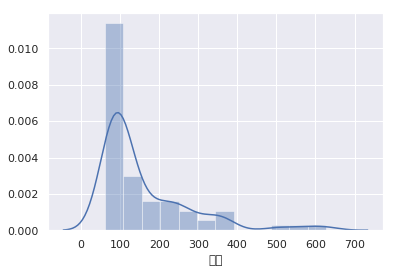

In [18]:
sns.distplot(df_normal['单价'])  #大于60的

In [ ]:
df_large